In [2]:
# 基本ライブラリ
import pandas as pd
import pandas.io.sql as psql
import numpy as np
import numpy.random as rd
import gc
import multiprocessing as mpa
import os
import sys
import pickle
from collections import defaultdict
from glob import glob
import math
from datetime import datetime as dt
from pathlib import Path
import scipy.stats as st
import re
from collections import Counter

# グラフ描画系
import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc

from matplotlib import animation as ani
from IPython.display import Image

plt.rcParams["patch.force_edgecolor"] = True
#rc('text', usetex=True)
from IPython.display import display # Allows the use of display() for DataFrames
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

#カラム内の文字数。デフォルトは50
pd.set_option("display.max_colwidth", 100)

#行数
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
#
pd.options.display.float_format = '{:,.5f}'.format

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
import pickle

def unpickle(filename):
    with open(filename, 'rb') as fo:
        p = pickle.load(fo)
    return p

def to_pickle(filename, obj):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, -1)

In [4]:
import pystan
from pystan import StanModel

In [5]:
K = 10   # num of topics
M = 100  # num of documents
V = 144  # num of words

rd.seed(123)
alpha = [0.8] * K
beta  = [0.2] * V
theta = rd.dirichlet(alpha, size=M)
phi   = rd.dirichlet(beta,  size=K)

In [6]:
# n_word_v: number of words per doc
n_word_v = np.round(np.exp(rd.normal(5.0, 0.3, size=M))).astype(int)     

In [7]:
n_word_v

array([184, 187, 175, 197, 189, 127,  96, 184, 163,  75,  89, 101, 145,
        98, 181, 127, 236, 169, 143, 168, 112, 229, 203, 160, 265,  96,
       189, 213, 172, 142,  80, 206, 131, 145, 200, 200, 105, 110, 120,
       182, 205, 173, 130, 142, 225, 106, 188, 144, 172, 150, 202, 174,
       152, 293, 216, 161, 187, 154, 121,  89, 276, 130, 177, 217, 130,
       137, 173, 174, 150, 108, 218, 187, 157, 189,  56, 151, 131,  82,
       175, 110, 227, 142, 181, 125, 190, 227,  93, 179,  91, 143, 160,
       107, 134, 233, 194, 202, 242, 135, 200, 124])

In [8]:
# トピック生成
topics_doc = []
for m, n_word in enumerate(n_word_v):
    topics = rd.multinomial(1, theta[m], size=n_word)    
    topics_doc.append(list(map(lambda x: np.argmax(x), topics)))

# 単語生成
word_in_docs = []
for doc in topics_doc:
    words = [np.argmax(rd.multinomial(1, phi[topic], size=1)[0]) for topic in doc]
    word_in_docs.append(list(map(lambda x: x+1, words)))

In [9]:
doc_nums = []
freq_list = []
flat_words = []
offset  = []
offset.append(0)
for doc_num, words in enumerate(word_in_docs):
    cnt = Counter(words)
    words = cnt.keys()
    freq = cnt.values()
    freq_list.extend(freq)
    flat_words.extend(words)
    doc_nums.extend([doc_num]*len(words))
    offset.append(offset[-1]+len(freq))
    
paired_offset = []
for i in range(len(offset)-1):
    paired_offset.append([offset[i]+1, offset[i+1]])

In [15]:
df_doc_words = pd.DataFrame({"doc":doc_nums, "word":flat_words, "cnt":freq_list})
df_doc_words.to_csv("word_list.csv")

In [17]:
df_doc_words[["doc", "word", "cnt"]].head(10)

,doc,word,cnt
0,0,103,7
1,0,45,4
2,0,37,1
3,0,28,3
4,0,134,2
5,0,42,5
6,0,52,5
7,0,98,14
8,0,67,1
9,0,70,6


In [ ]:
# http://statmodeling.hatenablog.com/entry/topic-model-4 に掲載のStanコードより
N = len(freq_list)

data ={
    "K": K,
    "M": M,
    "V": V,
    "N": N,
    "W": flat_words,
    "Freq": freq_list,
    "Offset": np.array(paired_offset),
    "Alpha": [1] * K,
    "Beta": [0.5]* V
}


stan = """
data {
   int<lower=2> K;                    # num topics
   int<lower=2> V;                    # num words
   int<lower=1> M;                    # num docs
   int<lower=1> N;                    # total word instances
   int<lower=1,upper=V> W[N];         # word n
   int<lower=1> Freq[N];              # frequency of word n
   int<lower=1,upper=N> Offset[M,2];  # range of word index per doc
   vector<lower=0>[K] Alpha;          # topic prior
   vector<lower=0>[V] Beta;           # word prior
}
parameters {
   simplex[K] theta[M];   # topic dist for doc m
   simplex[V] phi[K];     # word dist for topic k
}
model {
   # prior
   for (m in 1:M)
      theta[m] ~ dirichlet(Alpha);
   for (k in 1:K)
      phi[k] ~ dirichlet(Beta);

   # likelihood
   for (m in 1:M) {
      for (n in Offset[m,1]:Offset[m,2]) {
         real gamma[K];
         for (k in 1:K)
            gamma[k] <- log(theta[m,k]) + log(phi[k,W[n]]);
         increment_log_prob(Freq[n] * log_sum_exp(gamma));
      }
   }
}
"""

In [17]:
dt.now()

datetime.datetime(2019, 2, 18, 16, 33, 4, 263080)

In [19]:
%%time 
stm = StanModel(model_code=stan)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c8bacdf06012b3629ae8d1fd42a810ab NOW.


CPU times: user 907 ms, sys: 72.1 ms, total: 979 ms
Wall time: 1min 1s


In [20]:
%%time 
n_itr = 1000
n_warmup = 100
chains = 1

# サンプリングの実行
fit = stm.sampling(data=data, iter=n_itr, chains=chains, n_jobs=-1, warmup=n_warmup, algorithm="NUTS", verbose=False)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 12min 3s, sys: 3.55 s, total: 12min 7s
Wall time: 16min 39s


In [21]:
to_pickle("stan_lda_fit.pkl",fit)
to_pickle("stan_lda_model.pkl",stm)

/Users/kenichi.matsui/anaconda3/envs/kaggle_3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  # Remove the CWD from sys.path while we load stuff.


In [22]:
# fit = unpickle("stan_lda_fit.pkl")
# stm = unpickle("stan_lda_model.pkl")

In [23]:
la    = fit.extract(permuted=True)  # return a dictionary of arrays
# パラメーター名
names = fit.model_pars 
# パラメーターの数
n_param = np.sum([1 if len(x) == 0 else x[0] for x in fit.par_dims])

print(fit)

Inference for Stan model: anon_model_c8bacdf06012b3629ae8d1fd42a810ab.
1 chains, each with iter=1000; warmup=100; thin=1; 
post-warmup draws per chain=900, total post-warmup draws=900.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1,1]      0.04  1.1e-3   0.03 1.9e-3   0.02   0.04   0.06   0.11    751    1.0
theta[2,1]      0.06  1.3e-3   0.04 3.1e-3   0.03   0.05   0.08   0.15    881    1.0
theta[3,1]      0.05  1.3e-3   0.04 2.0e-3   0.02   0.04   0.07   0.14    788    1.0
theta[4,1]      0.04  1.1e-3   0.03 3.1e-3   0.02   0.04   0.06   0.12    839    1.0
theta[5,1]      0.02  4.1e-4   0.01 3.7e-4 5.3e-3   0.01   0.02   0.06   1271    1.0
theta[6,1]       0.1  1.8e-3   0.06 9.2e-3   0.06    0.1   0.14   0.23   1064    1.0
theta[7,1]      0.03  1.0e-3   0.03 1.0e-3   0.01   0.03   0.05   0.12    980    1.0
theta[8,1]      0.15  1.6e-3   0.05   0.07   0.12   0.15   0.18   0.25    899    1.0
theta[9,1]      0.05  1.1e-3   0.03 3.3e-3   0.03

In [24]:
summary = fit.summary()
EAP_theta = summary["summary"][:1000,0].reshape(10,100)
EAP_phi = summary["summary"][1000:-1,0].reshape(144,10)

In [27]:
cos = np.zeros((10,10))
for i in range(10):
    for j in range(10):
        x = EAP_phi[:,i]
        y = phi[j,:]
        cos[i,j] = np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y))

param_order = []
for c in cos:
    print(np.argmax(c), np.max(c))
    param_order.append(np.argmax(c))

7 0.9605561977606434
1 0.9360836551519953
3 0.9696619115702754
9 0.9691015636547261
4 0.9521082397046765
6 0.9665750687315983
0 0.9415094587050858
8 0.9327050163522562
2 0.9699700433788175
5 0.9587860072886027


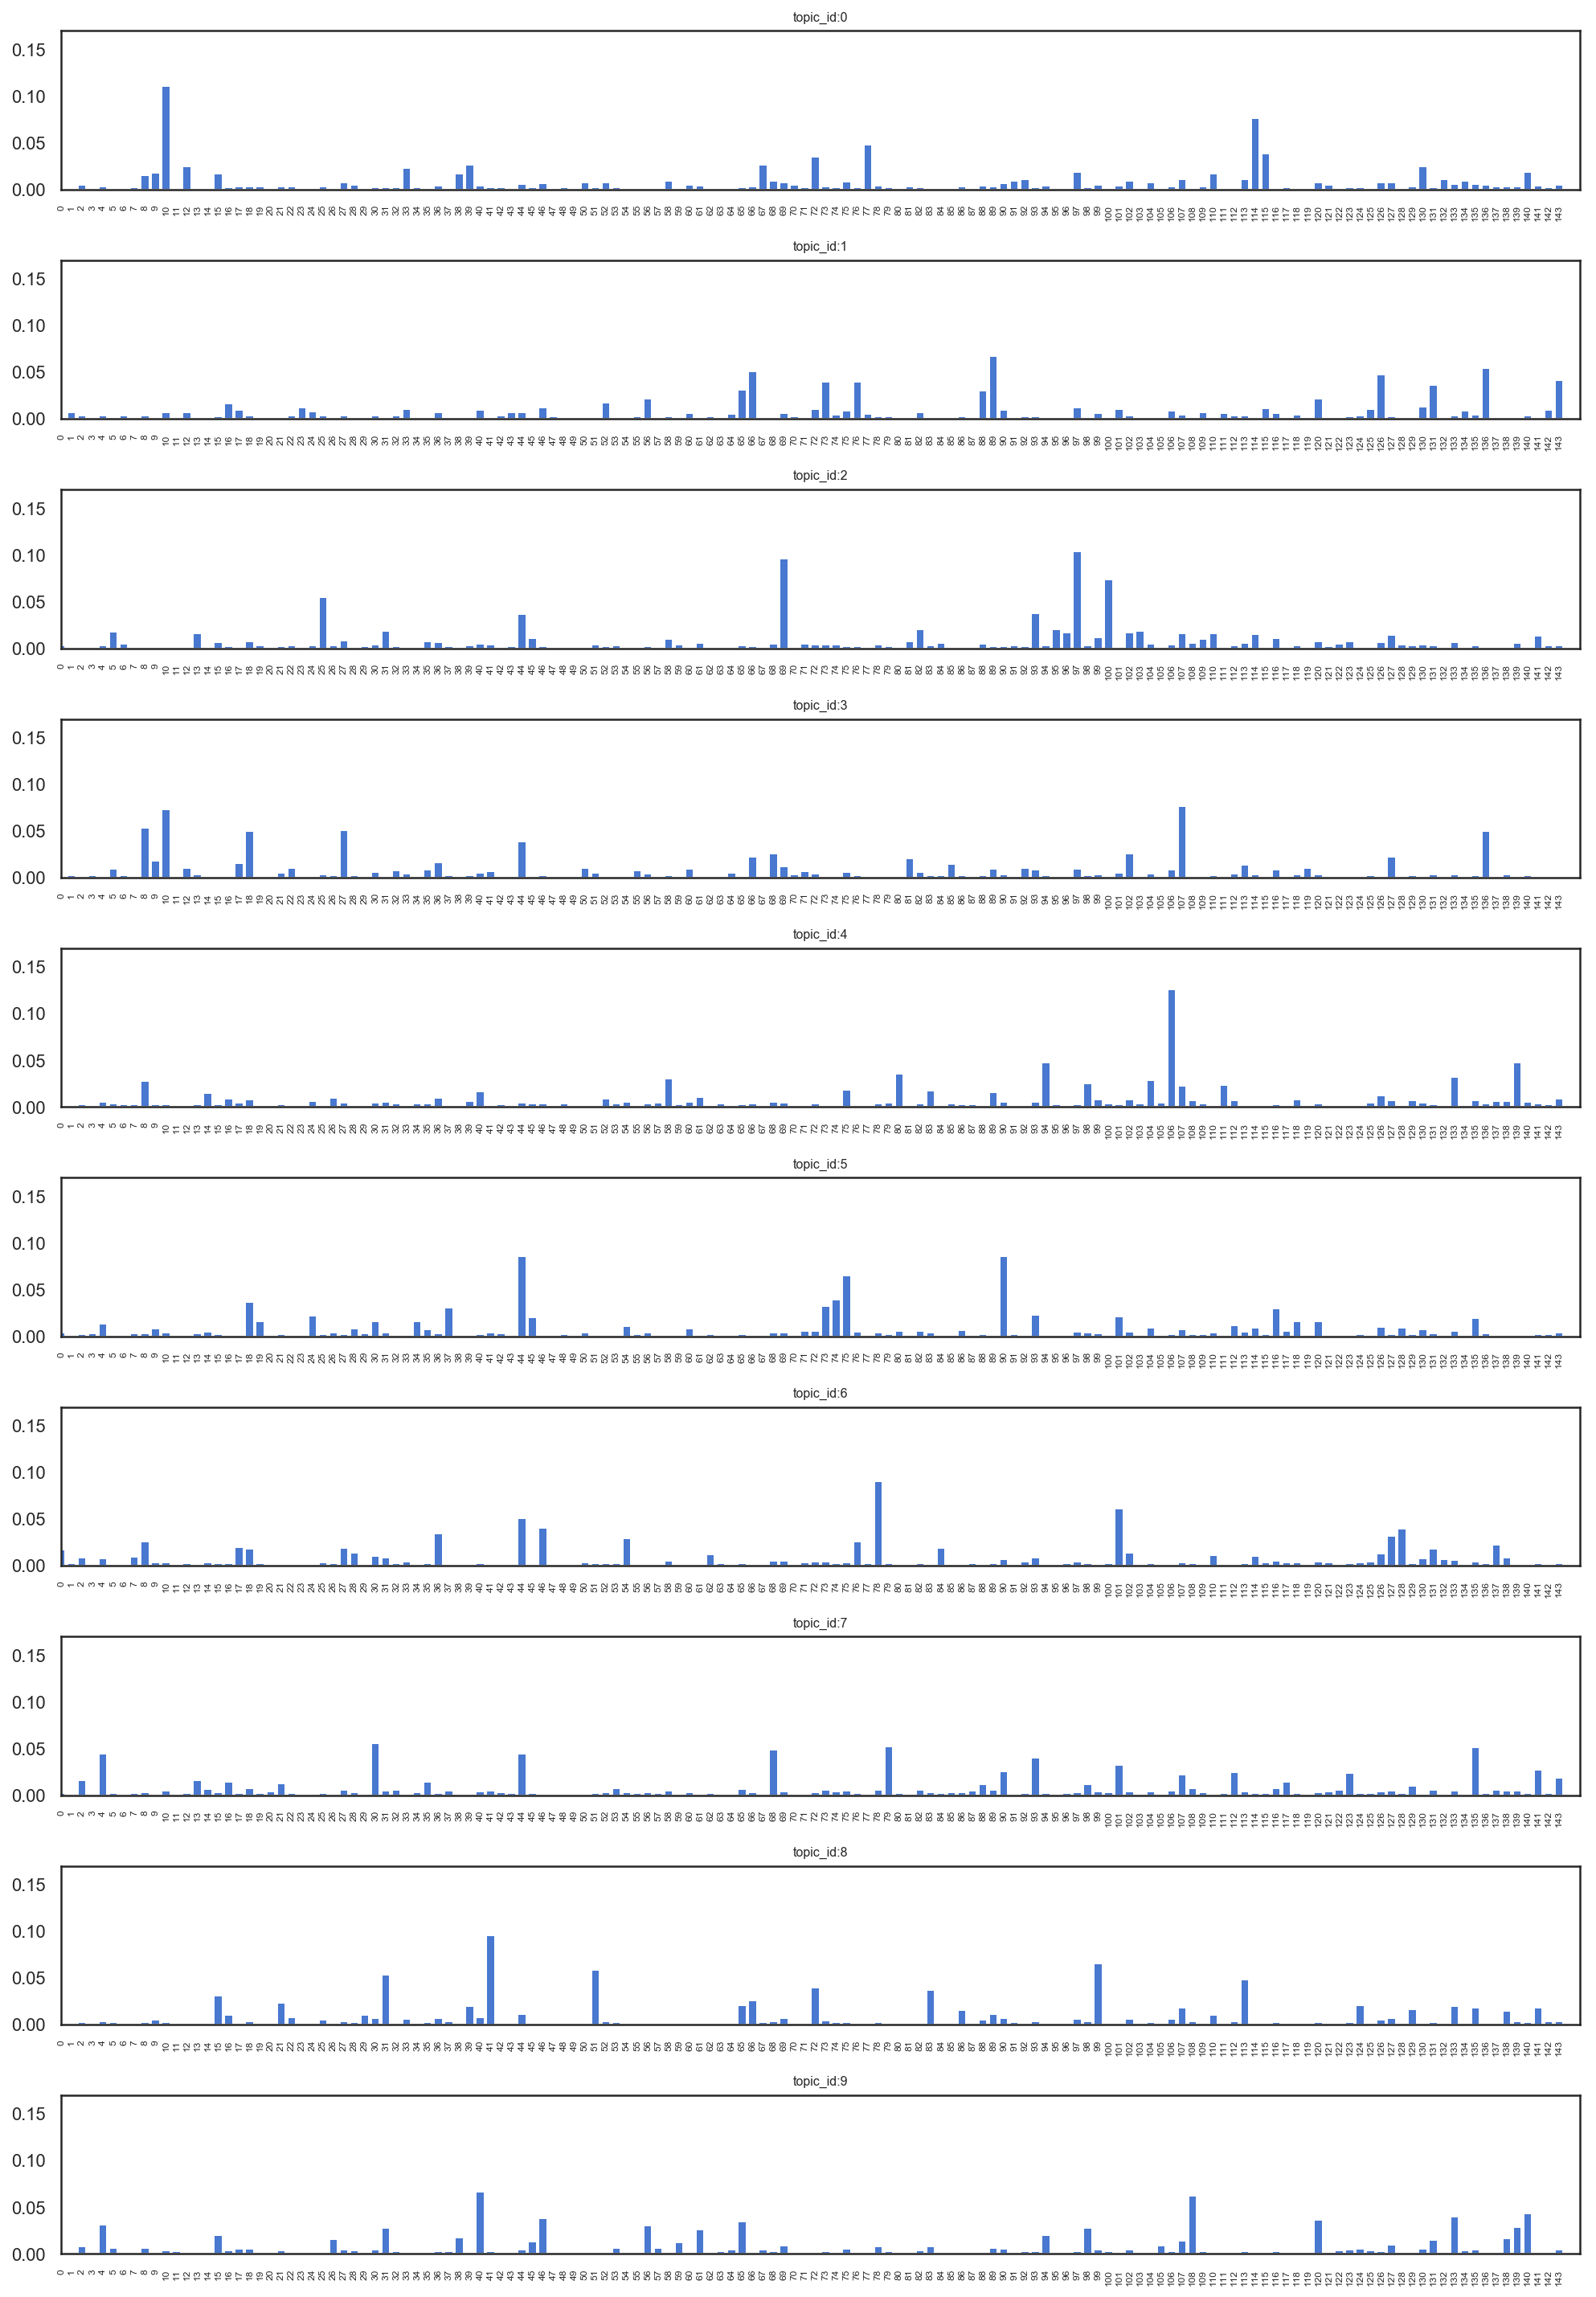

In [28]:
# word distribution(estimated)
sns.set(style="white", palette="muted", color_codes=True)
plt.figure(figsize=(14,20))
for i in range(K):
    plt.subplot(10,1,i+1)
    plt.bar(range(V), EAP_phi[:,i])
    plt.xticks(range(V), size=6, rotation='vertical')
    plt.yticks()
    plt.title("topic_id:{}".format(i), size=8)
    plt.xlim(0, 145)
    plt.ylim(0, .17)

plt.tight_layout()
plt.savefig("word_dist_EAP.png")

In [30]:
param_order

[7, 1, 3, 9, 4, 6, 0, 8, 2, 5]

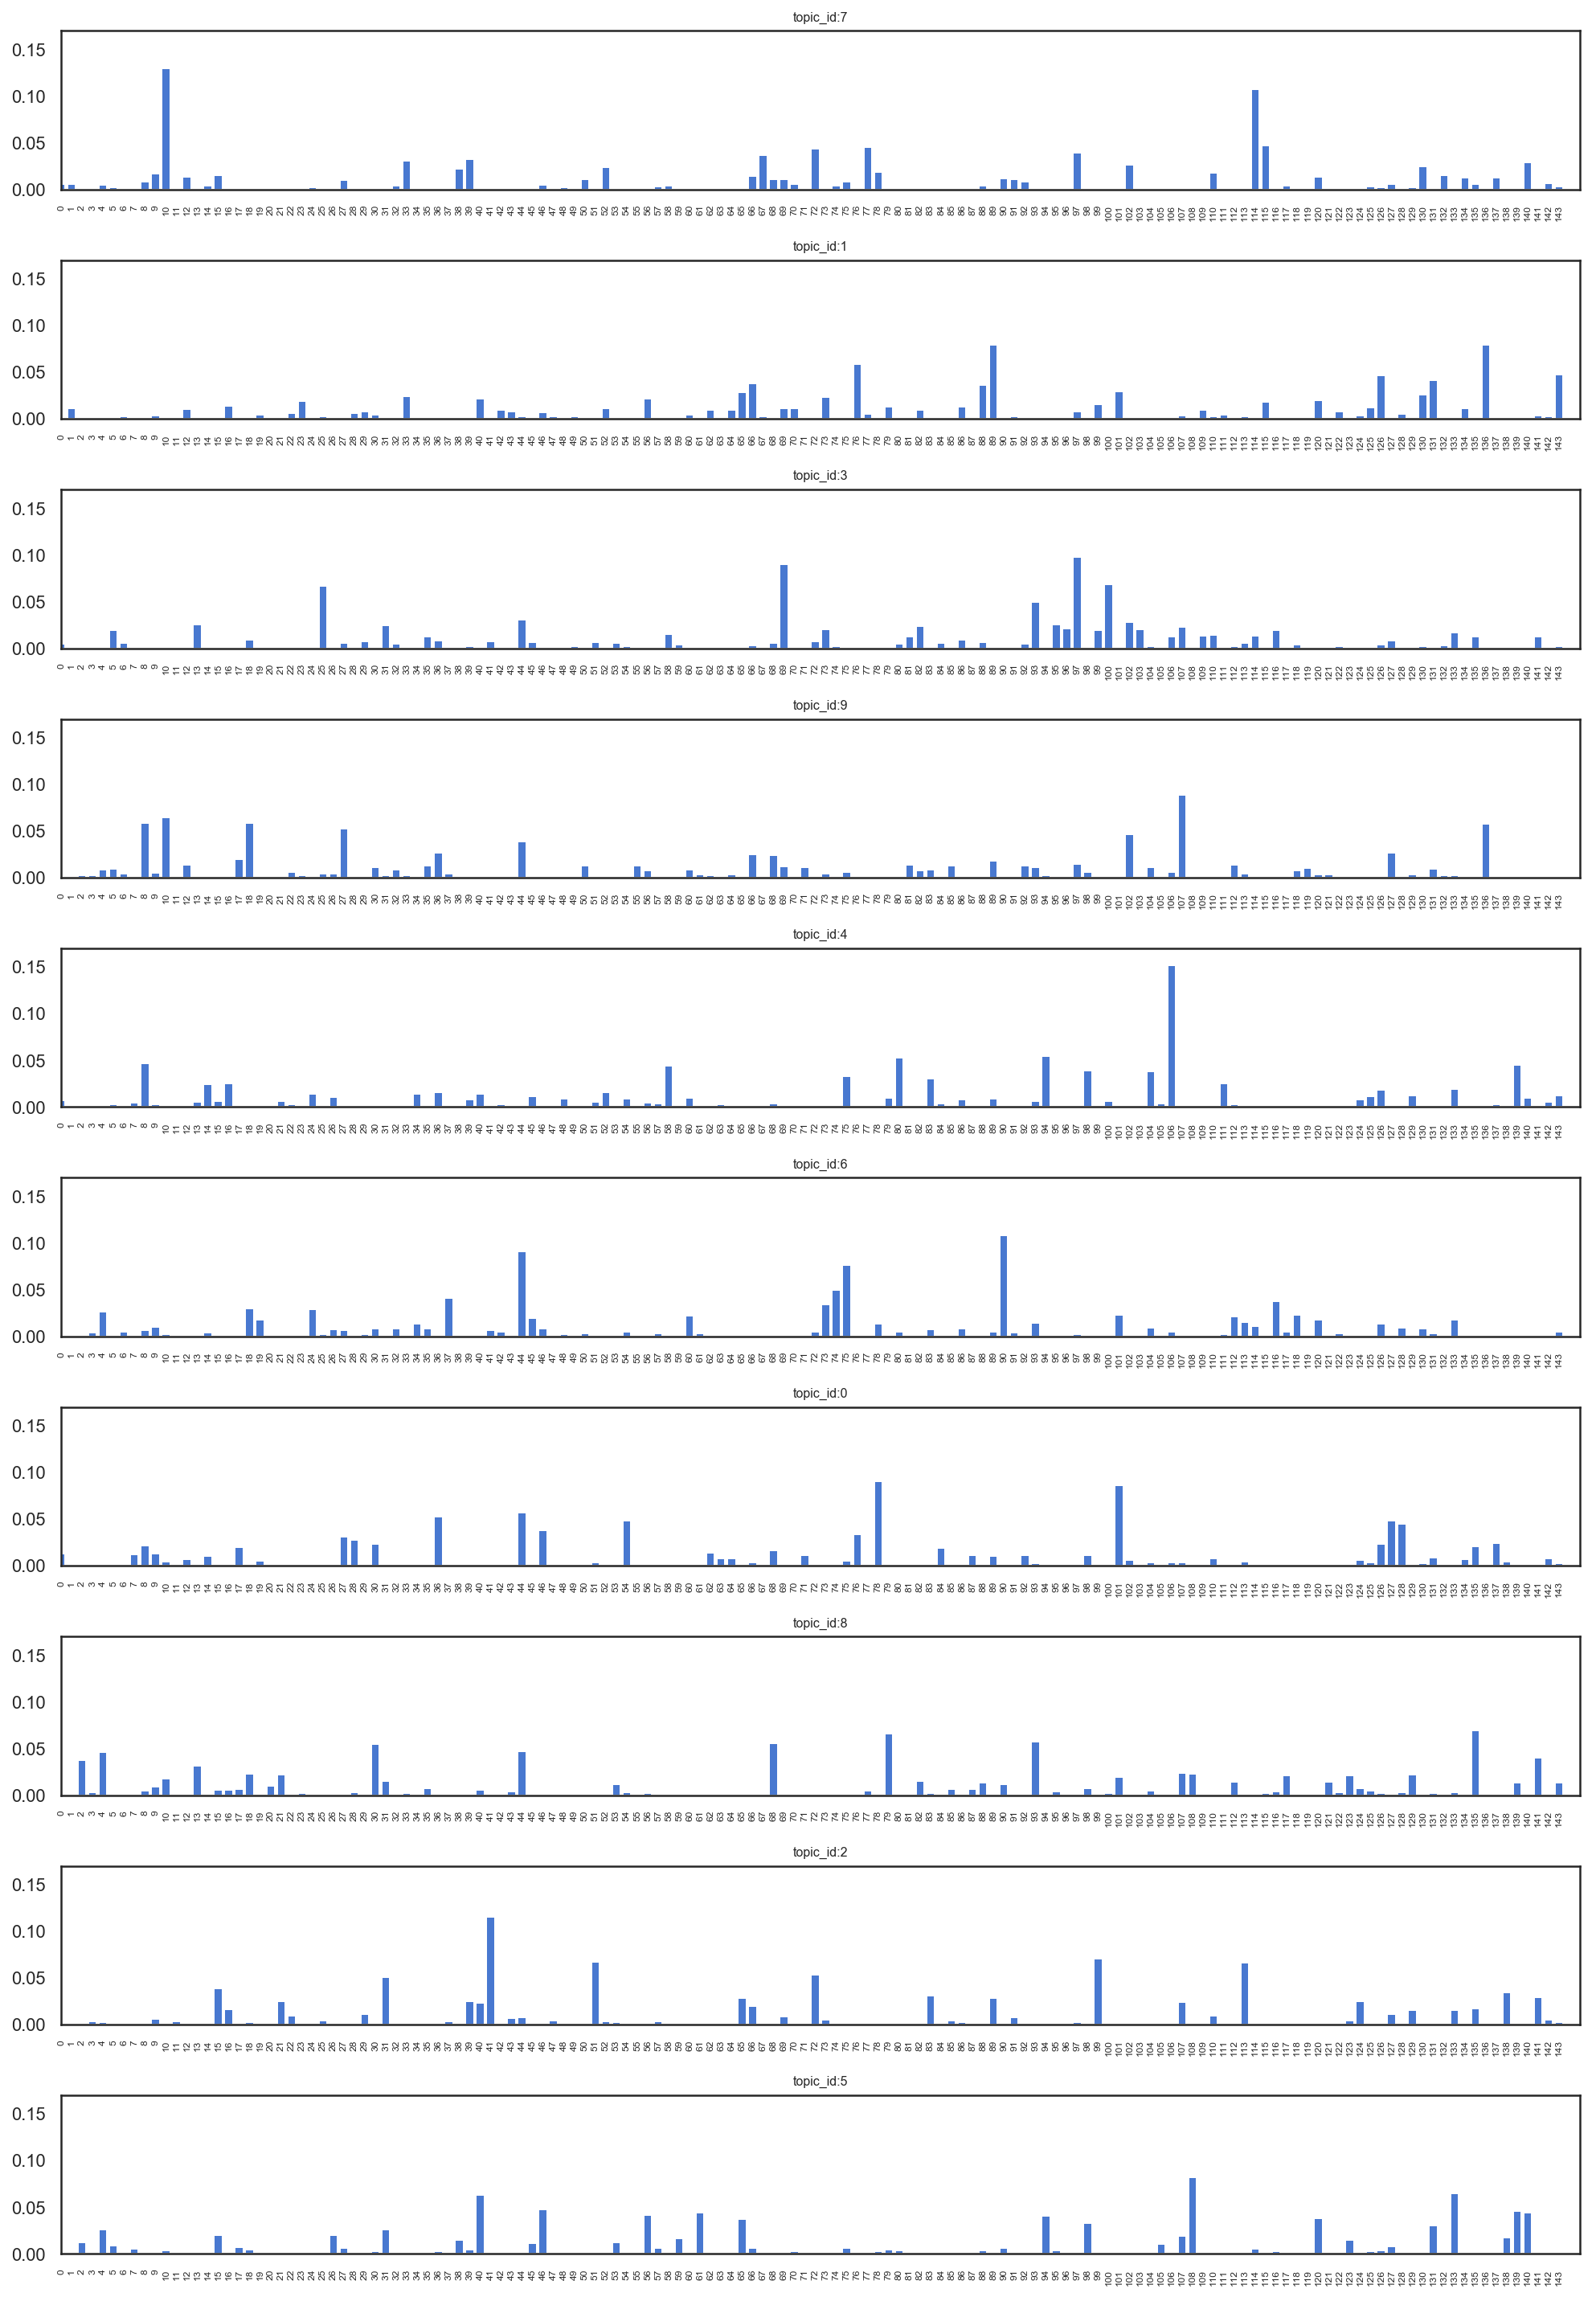

In [29]:
# word distribution(parameter)
sns.set(style="white", palette="muted", color_codes=True)
plt.figure(figsize=(14,20))
for i, topic in enumerate(param_order):
    plt.subplot(10,1,i+1)
    plt.bar(range(V), phi[topic,:])
    plt.xticks(range(V), size=6, rotation='vertical')
    plt.yticks()
    plt.title("topic_id:{}".format(topic), size=8)
    plt.xlim(0, 145)
    plt.ylim(0, .17)

plt.tight_layout()    
plt.savefig("word_dist.png")

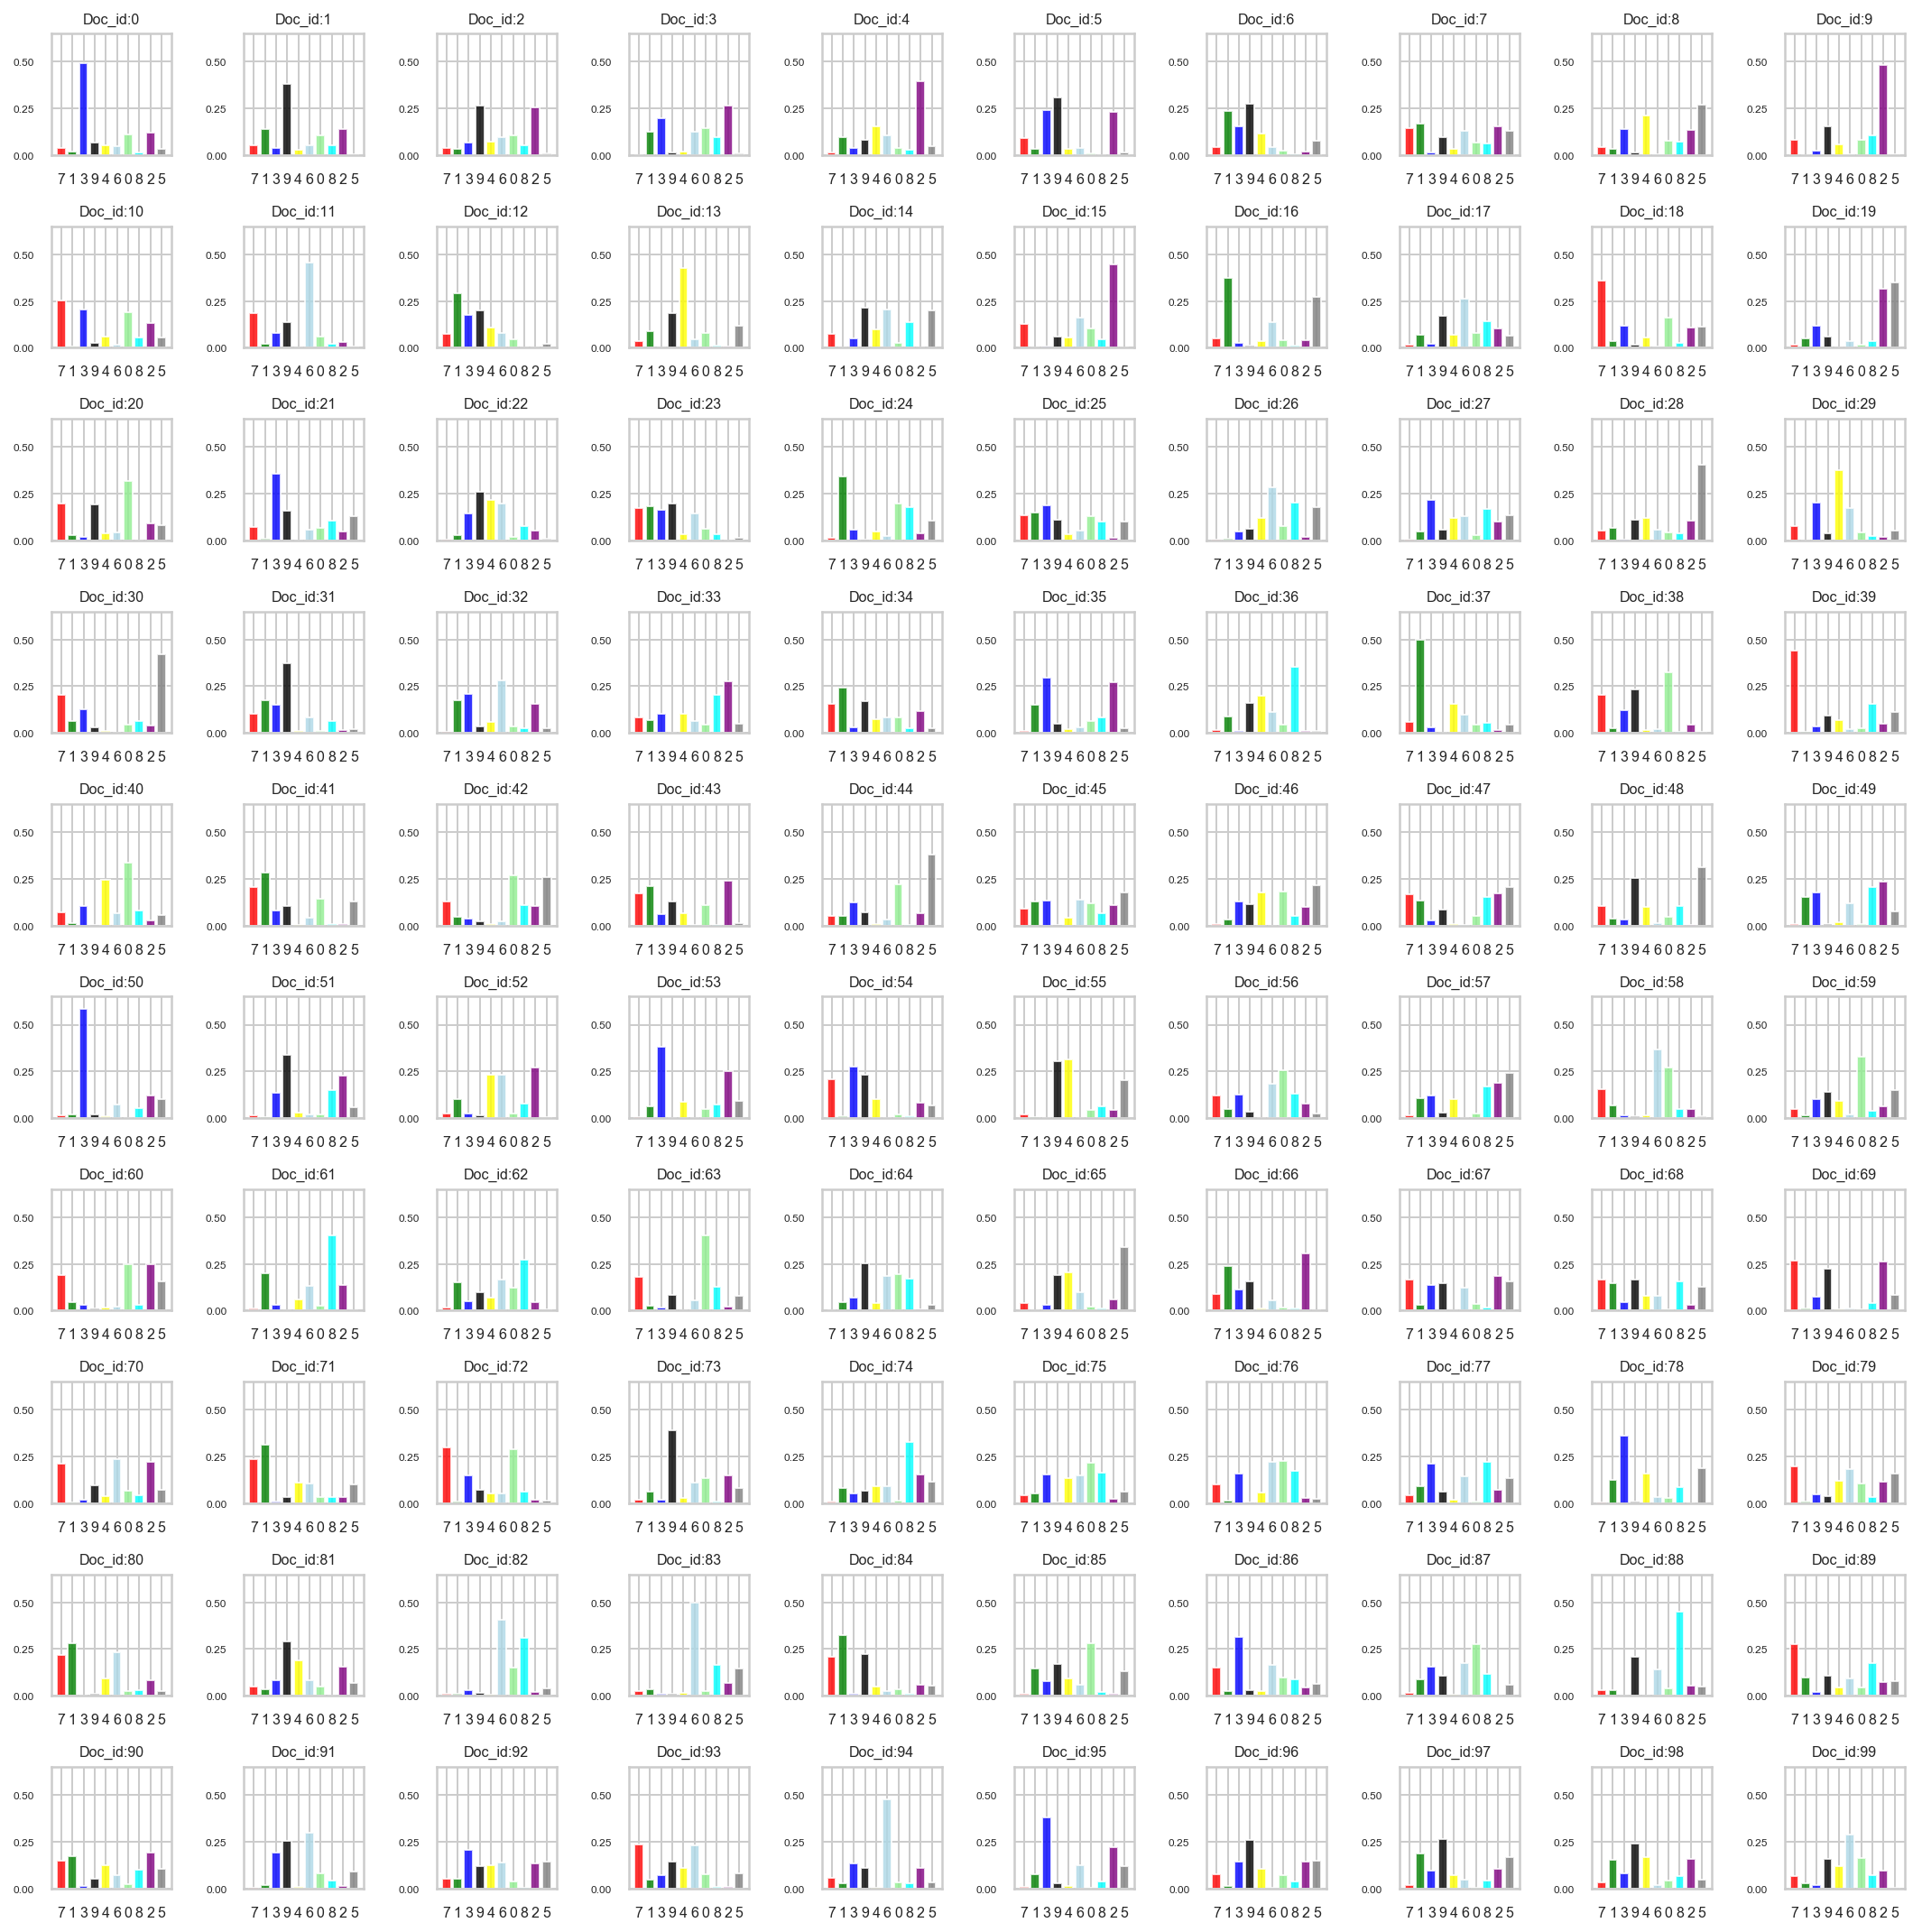

In [31]:
# parameter theta
sns.set(style="whitegrid", palette="muted", color_codes=True)
colors = "red,green,blue,black,yellow,lightblue,lightgreen,cyan,purple,gray".split(",")
plt.figure(figsize=(15,15))
plt.title("topic distribution(parameter)")
for i, t in enumerate(theta):
    #print t
    plt.subplot(K,K,i+1)
    plt.bar(range(K), t[param_order], color=colors, alpha=.8)
    plt.xticks(range(K), param_order, size=8)
    plt.yticks(size=6)
    plt.ylim(0, 0.65)
    plt.title("Doc_id:{}".format(i), size=8)

plt.tight_layout()    
plt.savefig("topic_dist.png")

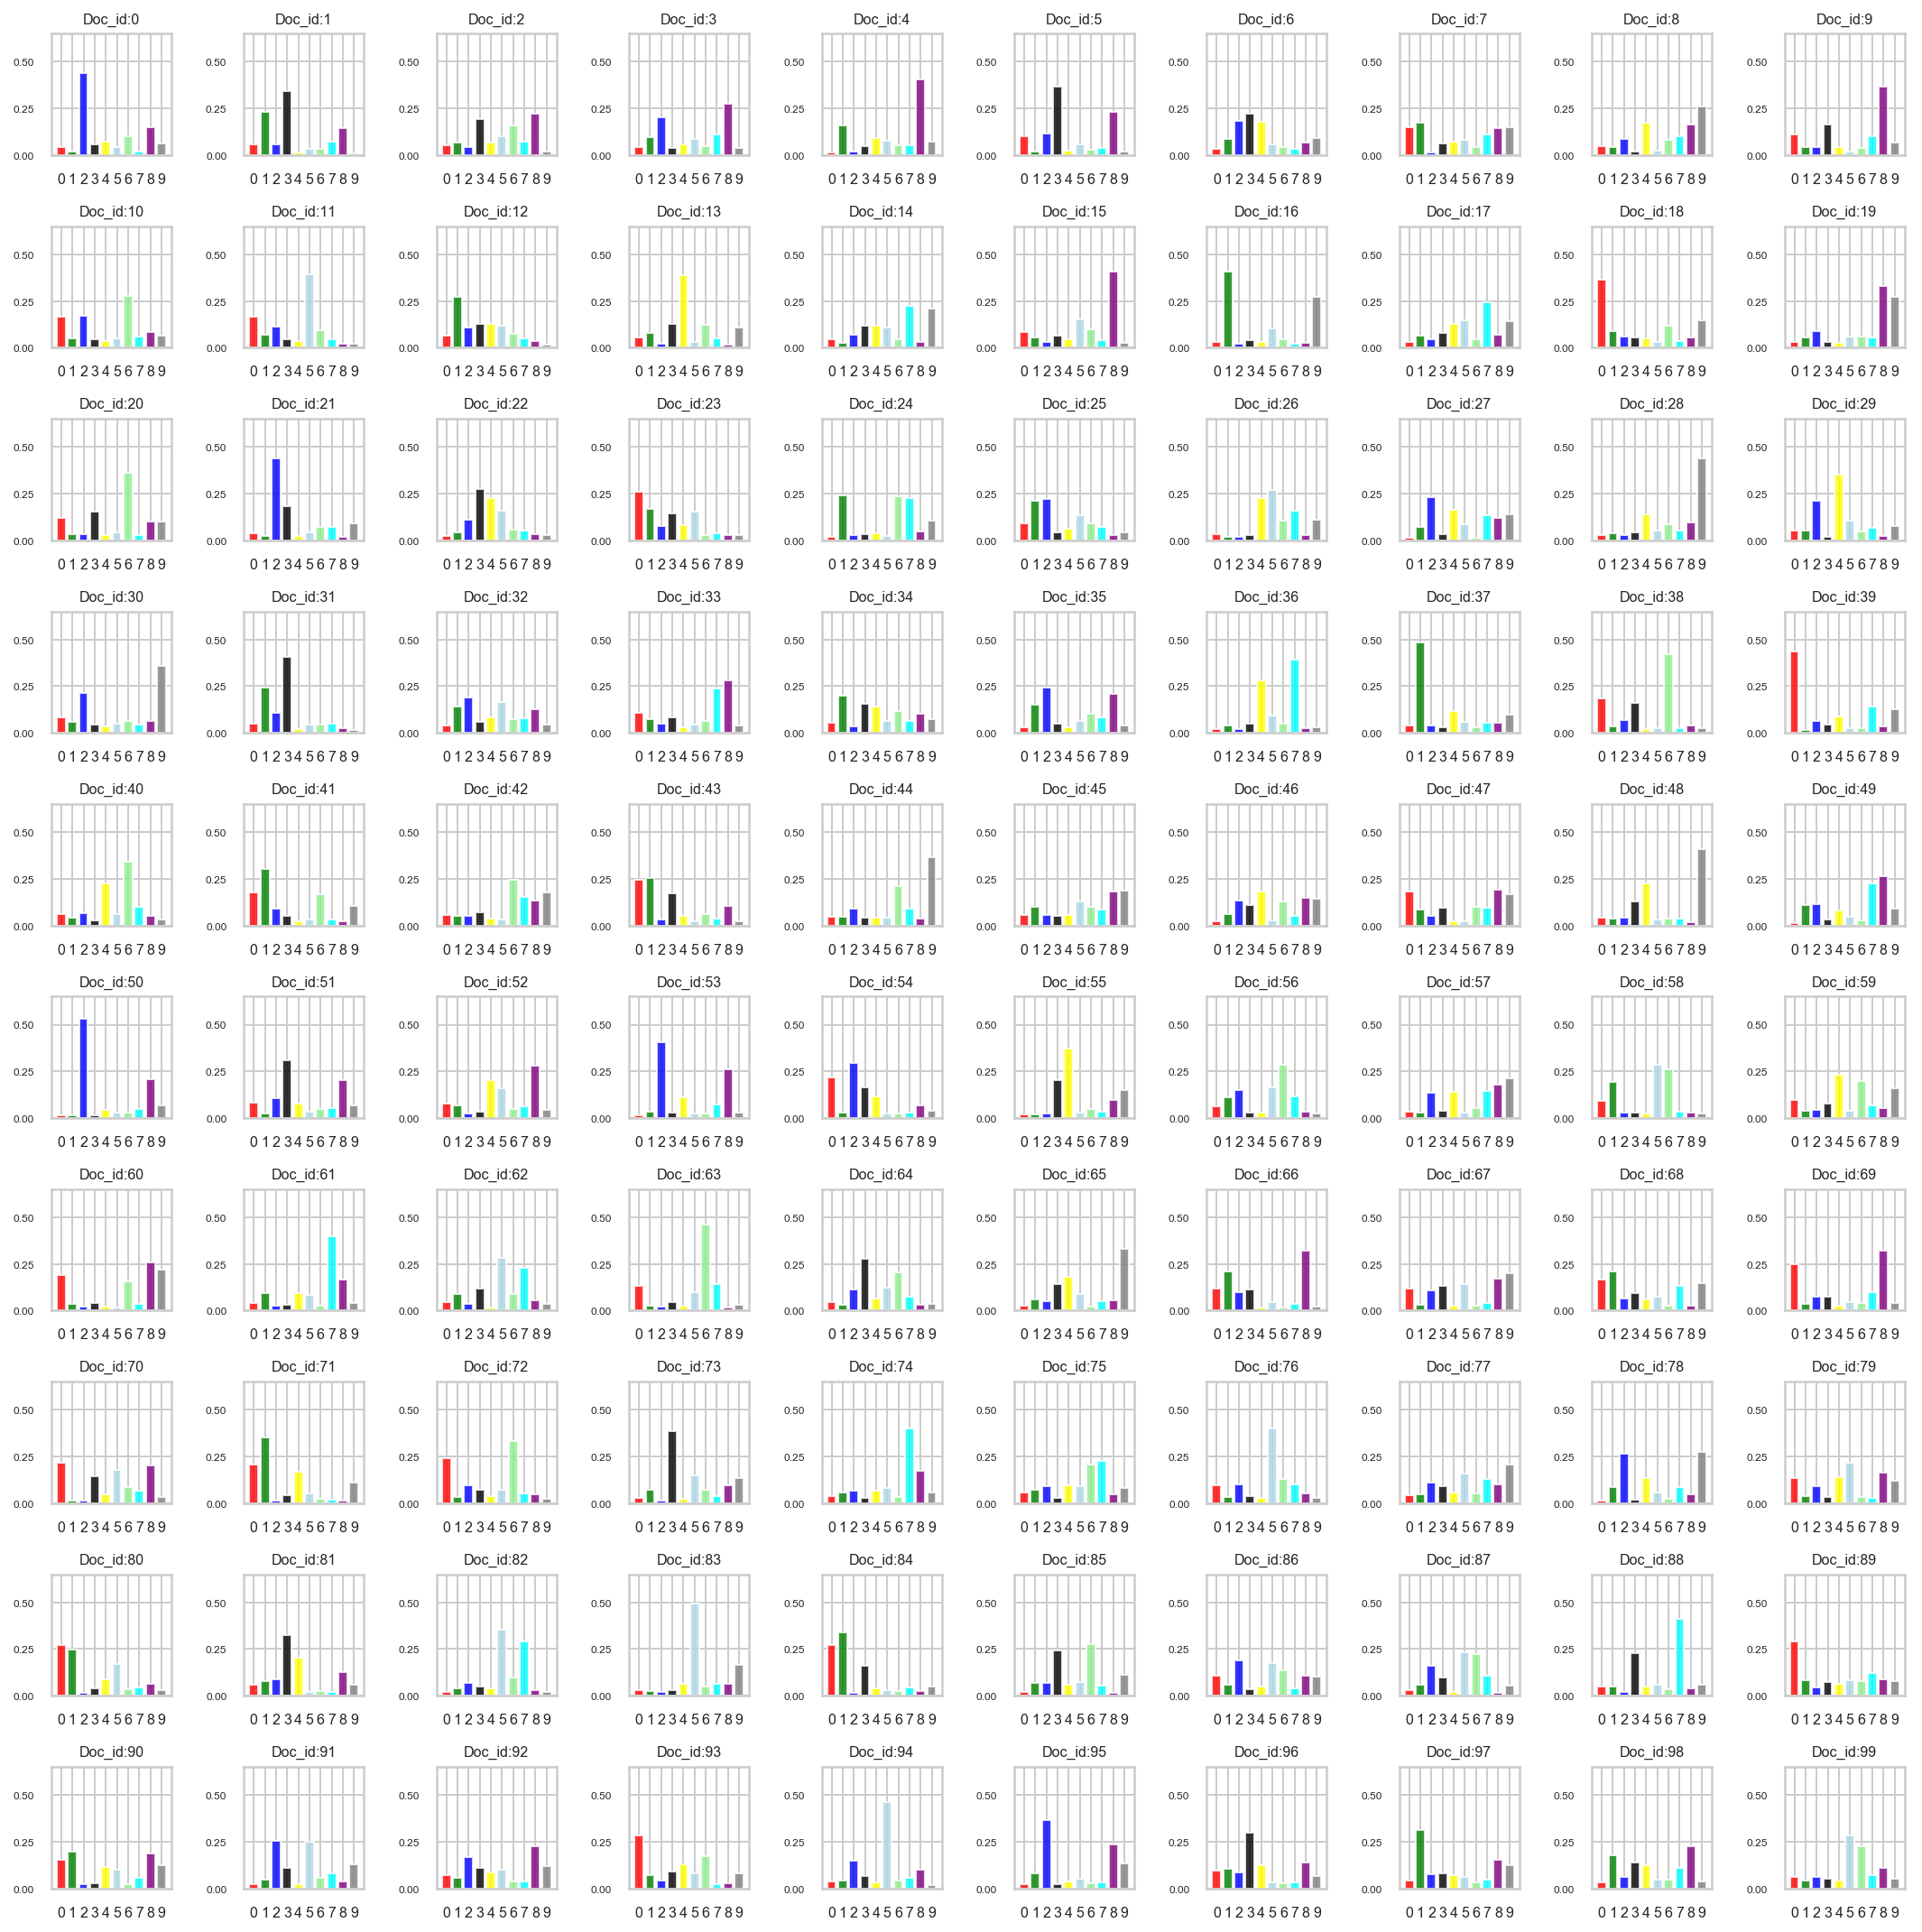

In [32]:
# topic distribution(estimated)
sns.set(style="whitegrid", palette="muted", color_codes=True)
colors = "red,green,blue,black,yellow,lightblue,lightgreen,cyan,purple,gray".split(",")
plt.figure(figsize=(15,15))
plt.title("topic distribution(EAP)")
for doc in range(M):
    plt.subplot(K,K,doc+1)
    #target = np.sort(EAP_theta[:,doc])
    plt.bar(range(K), EAP_theta[:,doc], color=colors, alpha=.8)
    plt.xticks(range(K), size=8)
    plt.yticks(size=6)
    plt.ylim(0, 0.65)
    plt.title("Doc_id:{}".format(doc), size=8)

plt.tight_layout()   
plt.savefig("topic_dist_EAP.png")

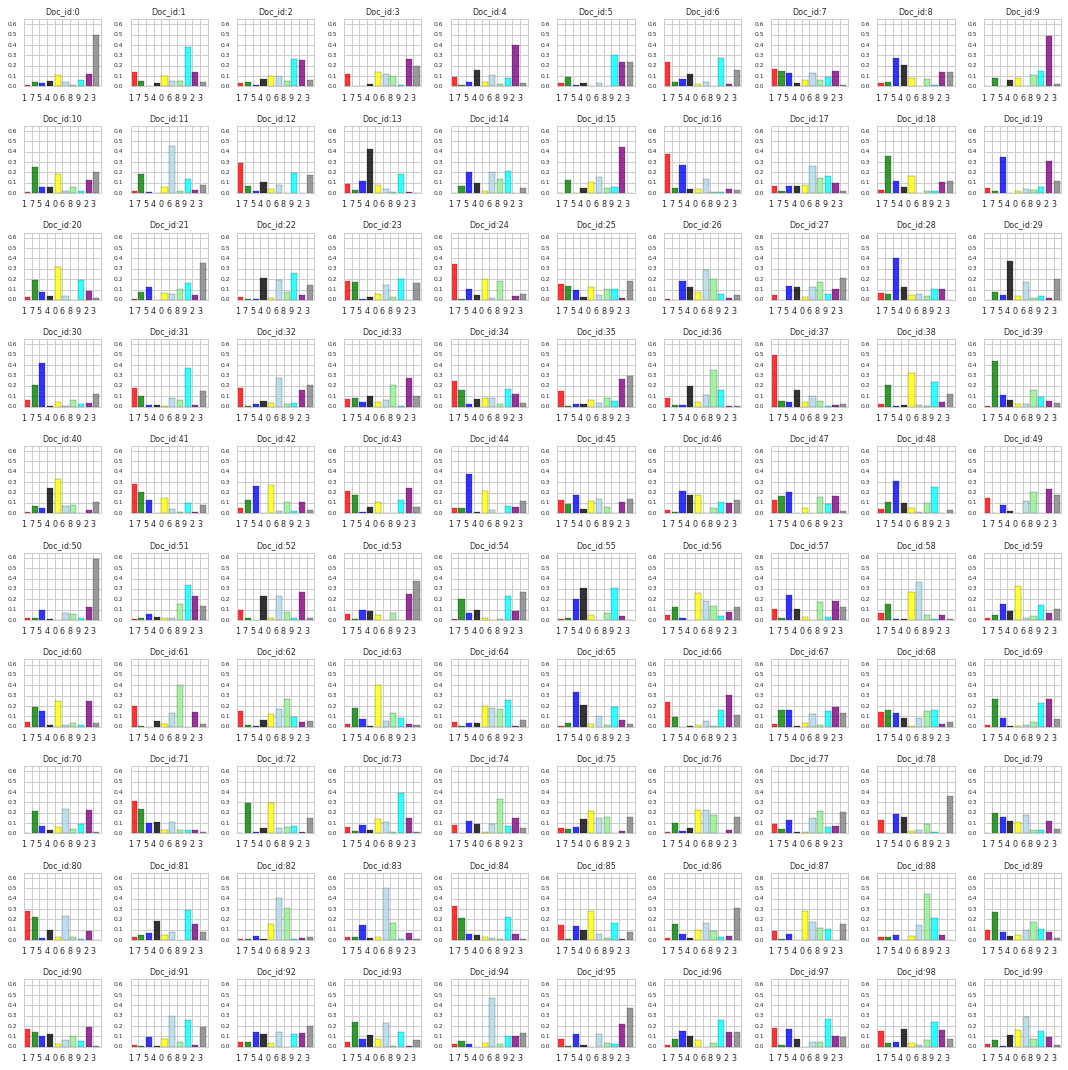

### Trace Plot

/Users/kenichi.matsui/anaconda3/envs/kaggle_3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/Users/kenichi.matsui/anaconda3/envs/kaggle_3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


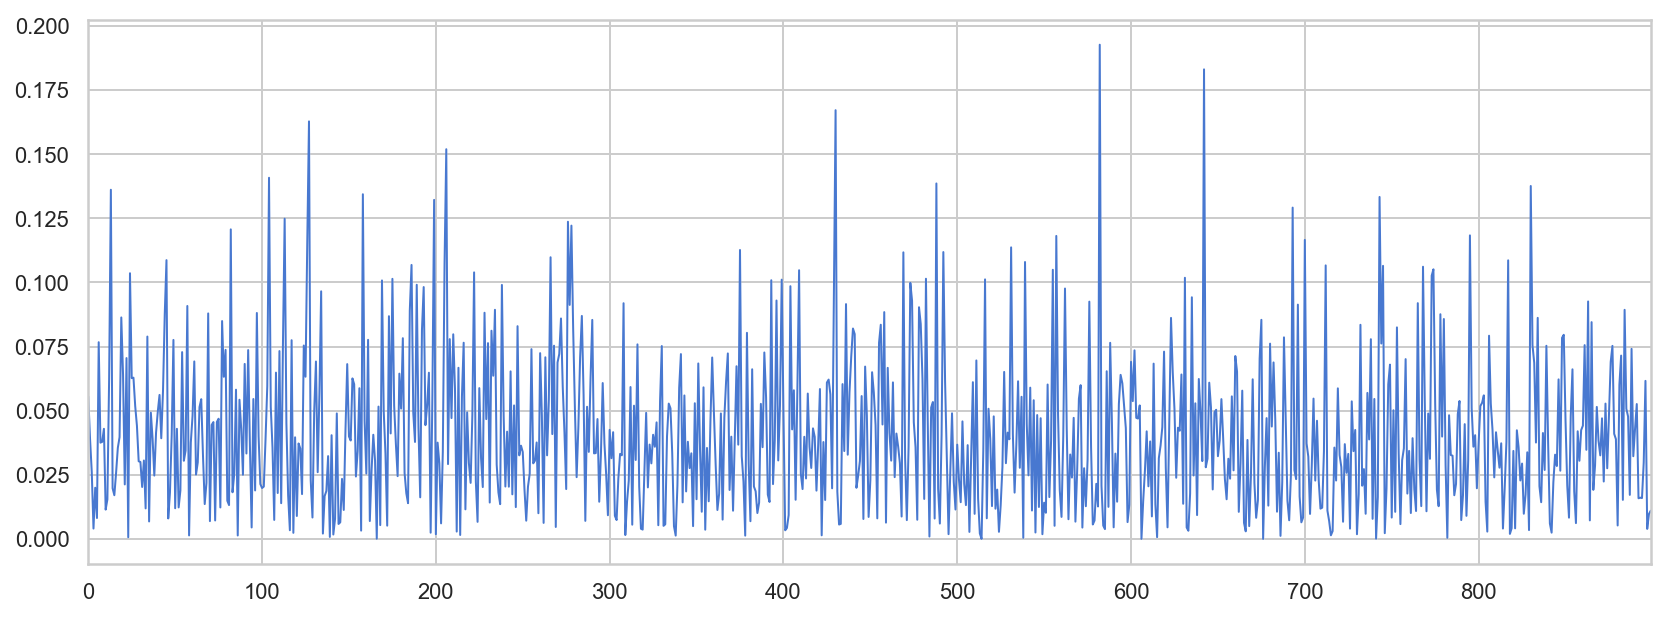

In [33]:
plt.figure(figsize=(14,5))
ax = plt.subplot()
sns.tsplot(la['theta'][:,0,0], lw=1, ax=ax)

/Users/kenichi.matsui/anaconda3/envs/kaggle_3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/Users/kenichi.matsui/anaconda3/envs/kaggle_3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


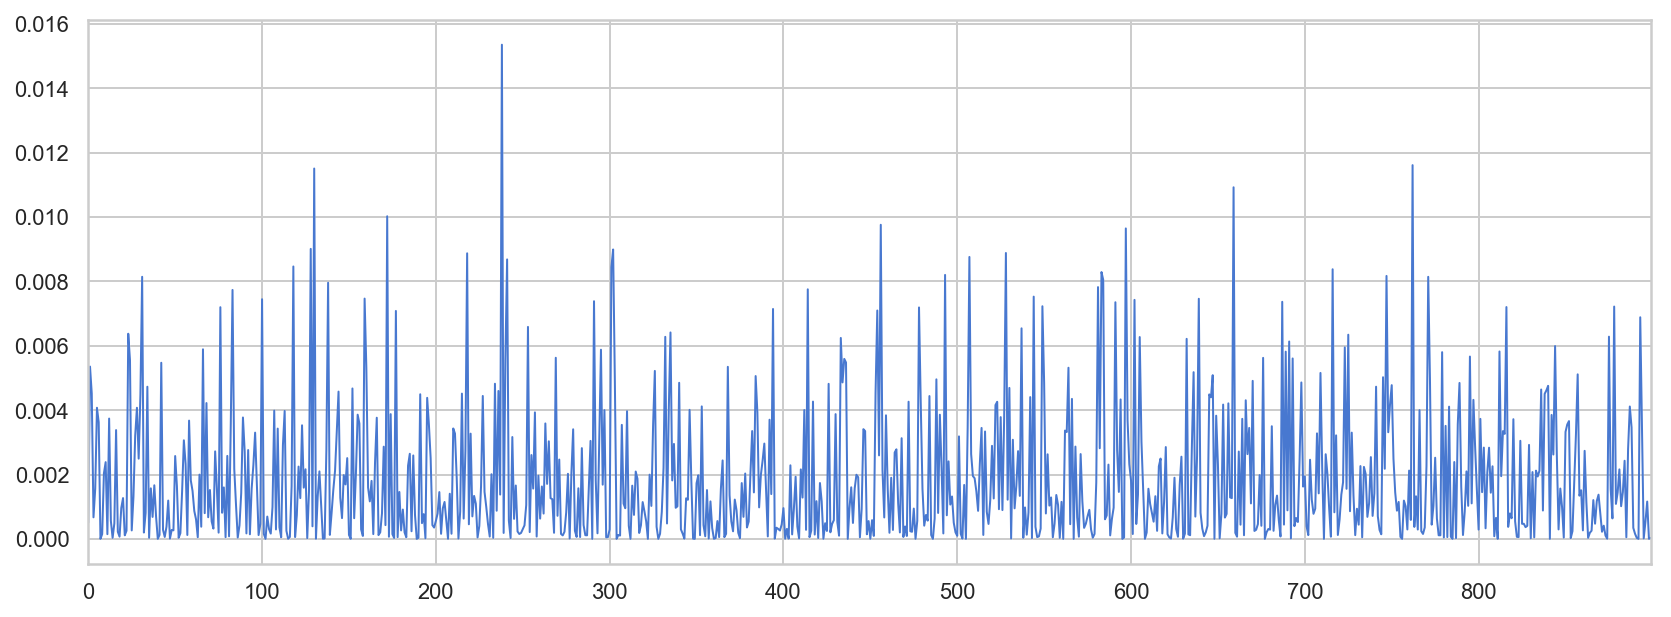

In [34]:
plt.figure(figsize=(14,5))
ax = plt.subplot()
sns.tsplot(la['phi'][:,0,0], lw=1, ax=ax)

### 分布の可視化

/Users/kenichi.matsui/anaconda3/envs/kaggle_3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


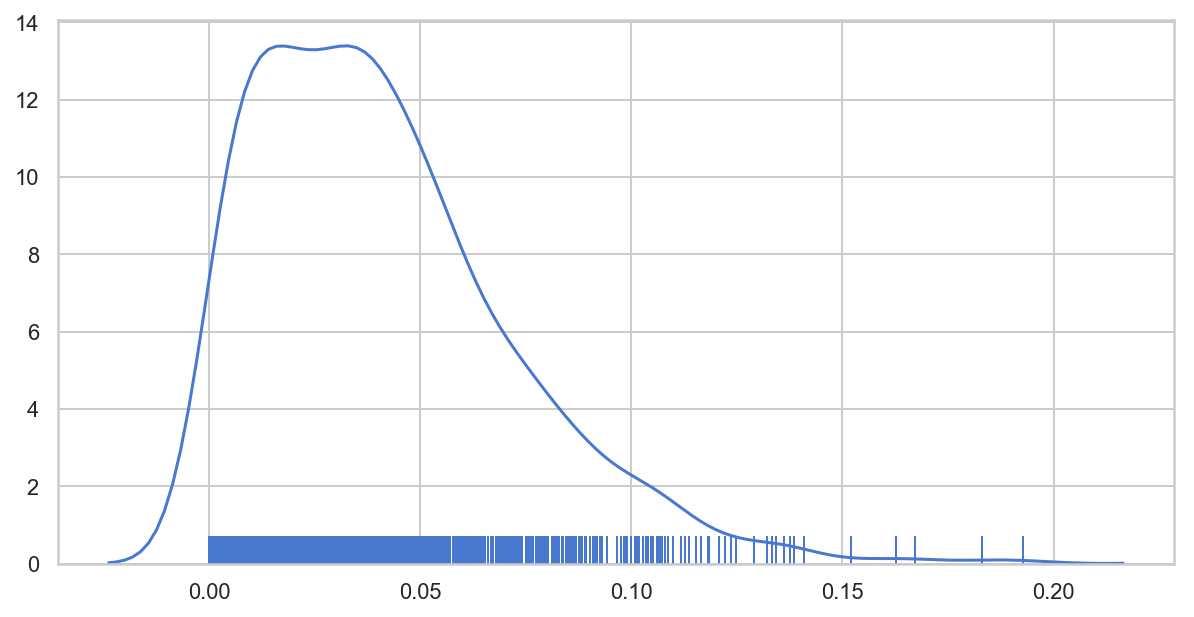

In [35]:
plt.figure(figsize=(10,5))
ax = plt.subplot()
sns.distplot(la['theta'][:,0,0], hist=False, rug=True, ax=ax)

/Users/kenichi.matsui/anaconda3/envs/kaggle_3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


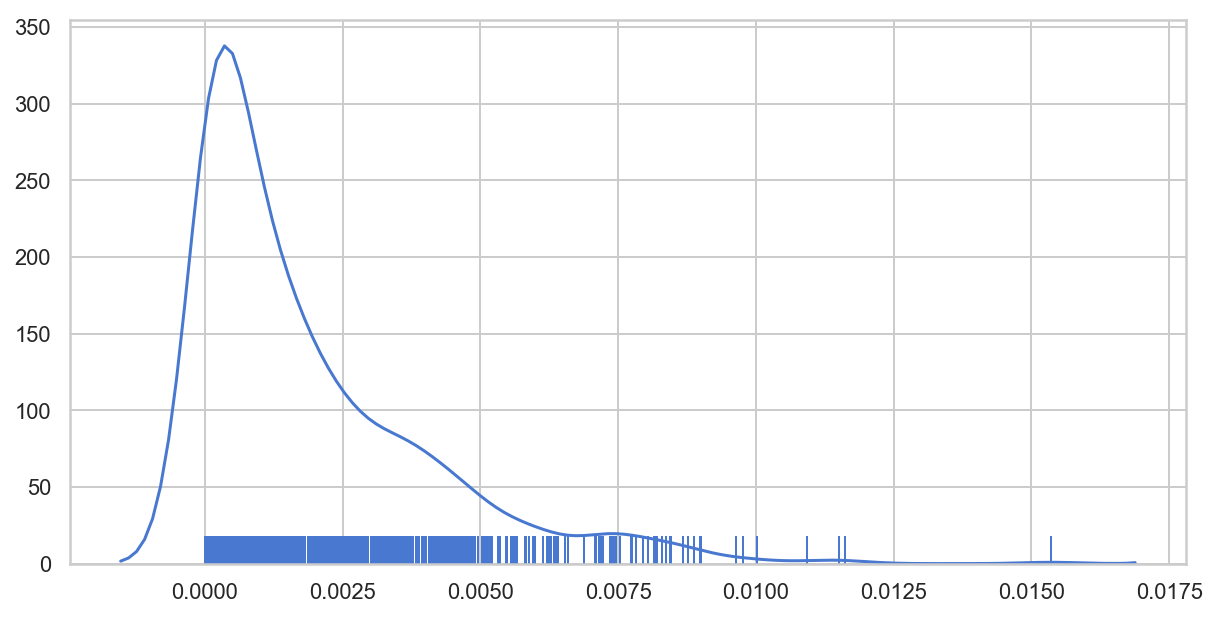

In [36]:
plt.figure(figsize=(10,5))
ax = plt.subplot()
sns.distplot(la['phi'][:,0,0], hist=False, rug=True, ax=ax)

In [ ]:
la['']